# Arabic Dialect Classifier
This notebook contains the training of the classifier model. The goal is to classify the dialects at the country level.

In [1]:
import pickle

from datasets import DatasetDict, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
import torch
from transformers import AutoModel, AutoTokenizer
import xgboost as xgb

/home/mehdi/miniconda3/envs/adc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Exploring the Dataset

In [2]:
df_train = pd.read_csv("../data/DA_train_labeled.tsv", sep="\t")
df_test = pd.read_csv("../data/DA_dev_labeled.tsv", sep="\t")

In [3]:
df_train.head()

,#1_tweetid,#2_tweet,#3_country_label,#4_province_label
0,TRAIN_0,حاجة حلوة اكيد,Egypt,eg_Faiyum
1,TRAIN_1,عم بشتغلوا للشعب الاميركي اما نحن يكذبوا ويغشو...,Iraq,iq_Dihok
2,TRAIN_2,ابشر طال عمرك,Saudi_Arabia,sa_Ha'il
3,TRAIN_3,منطق 2017: أنا والغريب علي إبن عمي وأنا والغري...,Mauritania,mr_Nouakchott
4,TRAIN_4,شهرين وتروح والباقي غير صيف ملينا,Algeria,dz_El-Oued


In [4]:
df_test.head()

,#1_tweetid,#2_tweet,#3_country_label,#4_province_label
0,DEV_0,قولنا اون لاين لا يا علي اون لاين لا,Egypt,eg_Alexandria
1,DEV_1,ههههه بايخه ههههه URL …,Oman,om_Muscat
2,DEV_2,ربنا يخليك يا دوك ولك المثل :D,Lebanon,lb_South-Lebanon
3,DEV_3,#اوامر_ملكيه ياشباب اي واحد فيكم عنده شي يذكره...,Syria,sy_Damascus-City
4,DEV_4,شد عالخط حتى هيا اكويسه,Libya,ly_Misrata


In [5]:
df_train.isnull().sum(), df_test.isnull().sum()

(#1_tweetid           0
 #2_tweet             0
 #3_country_label     0
 #4_province_label    0
 dtype: int64,
 #1_tweetid           0
 #2_tweet             0
 #3_country_label     0
 #4_province_label    0
 dtype: int64)

Let's look at the distribution of the labels

Text(0.5, 1.0, 'Value counts of country label in train data')

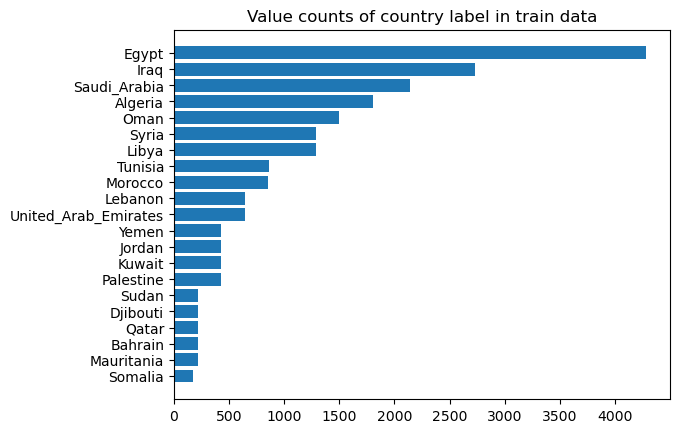

In [6]:
plt.barh(y=df_train["#3_country_label"].value_counts().sort_values(ascending=True).index,
         width=df_train["#3_country_label"].value_counts().sort_values(ascending=True))
plt.title("Value counts of country label in train data")

Text(0.5, 1.0, 'Value counts of country label in test data')

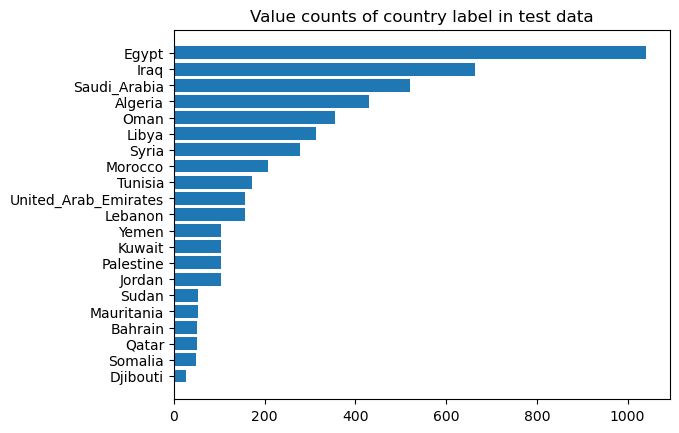

In [7]:
plt.barh(y=df_test["#3_country_label"].value_counts().sort_values(ascending=True).index,
         width=df_test["#3_country_label"].value_counts().sort_values(ascending=True))
plt.title("Value counts of country label in test data")

Some countries don't have a lot of observations, which means that it might be harder to detect their dialects. We need to take this into consideration when training and evaluating the model (by assigning weights/oversampling, and by choosing appropriate evaluation metrics).

## 2. Training the Classifier

For this classifier, we will convert the tweets into vector embeddings using the AraBART model. We will use the last hidden layer of the model to extract the features

### 2.1 Data Preparation
The first step is to prepare our data by tokenizing it to use it with the model AraBART.

First, we load the model and its tokenizer.

In [8]:
device = torch.device("cuda")
type(device)

torch.device

In [9]:
model = AutoModel.from_pretrained("moussaKam/AraBART").to(device)
tokenizer = AutoTokenizer.from_pretrained("moussaKam/AraBART")

Next, we convert the datasets into a DatasetDict object.

In [10]:
mapper = {"#2_tweet": "tweet", "#3_country_label": "label"}
columns_to_keep = ["tweet", "label"]

df_train = df_train.rename(columns=mapper)[columns_to_keep]
df_test = df_test.rename(columns=mapper)[columns_to_keep]

train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)
data = DatasetDict({'train': train_dataset, 'test': test_dataset})

Then, we tokenkize the dataset.

In [11]:
def tokenize(batch):
  return tokenizer(batch["tweet"], padding=True)

data_encoded = data.map(tokenize, batched=True, batch_size=None)

In [12]:
data_encoded["train"].column_names

['tweet', 'label', 'input_ids', 'attention_mask']

### 2.2 Feature Extraction

Now, we will extract the output of the last hidden layer of AraBART, and use those embeddings as the features of our classifier.

In [13]:
def extract_hidden_states(batch):
  inputs = {k:v.to(device) for k,v in batch.items()
            if k in tokenizer.model_input_names}
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state

  return{"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [14]:
data_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
data_hidden = data_encoded.map(extract_hidden_states, batched=True, batch_size=50)

In [16]:
with open("../data/data_hidden.pkl", "wb") as f:
    pickle.dump(data_hidden, f)

In [2]:
with open("../data/data_hidden.pkl", "rb") as f:
    data_hidden = pickle.load(f)

### 2.3 Model Training

Now, we only need to convert the data into numpy arrays, and we are ready to train the models.

In [3]:
X_train = np.array(data_hidden["train"]["hidden_state"])
X_test = np.array(data_hidden["test"]["hidden_state"])
y_train = np.array(data_hidden["train"]["label"])
y_test = np.array(data_hidden["test"]["label"])

X_train.shape, y_train.shape

((21000, 768), (21000,))

We can try different models.  

For the ensemble models, we can do a randomized or grid search to tune the hyperparameters. We will use a 5-fold cross validation strategy, and optimize for the macro averaged f1 score (because we want to give an equal importance to each class, regardless of how many observations each one has).

#### 2.3.1 Logistic Regression 

In [32]:
lr_model = LogisticRegression(multi_class='multinomial', 
                              class_weight="balanced", 
                              max_iter=1000, 
                              random_state=2024)
lr_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', random_state=2024)

#### 2.3.2 Random Forest

In [39]:
rf_model = RandomForestClassifier(class_weight="balanced", random_state=2024)
parameters = {
    "n_estimators": [100, 150, 200, 250, 300, 400, 500],
    "max_depth": [3, 4, 5, 6, 7, 8]
}
rf_search = RandomizedSearchCV(estimator=rf_model, param_distributions=parameters, 
                         scoring="f1_macro", cv=5, n_iter=20)
rf_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=2024),
                   n_iter=20,
                   param_distributions={'max_depth': [3, 4, 5, 6, 7, 8],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300, 400, 500]},
                   scoring='f1_macro')

In [40]:
print("Best Parameters:", rf_search.best_params_)
print("Best Score:", rf_search.best_score_)

Best Parameters: {'n_estimators': 400, 'max_depth': 8}
Best Score: 0.15591886021384346


#### 2.3.3 XGBoost

For XGBoost, we first need to encode the target variable.

In [4]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
xgb_model = xgb.XGBClassifier(device="cuda", seed=2024)
parameters = {
    "n_estimators" : [100, 150, 200, 300, 400, 450, 500],
    "max_depth" : [3, 4, 5, 6, 7, 8],
    "learning_rate": [0.1, 0.05, 0.01, 0.005, 0.001]
}
xgb_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=parameters,
                                scoring="f1_macro", cv=5, n_iter=20)
xgb_search.fit(X_train, y_train_encoded)

In [ ]:
print("Best Parameters:", xgb_search.best_params_)
print("Best Score (Macro Average F1):", xgb_search.best_score_)

The best parameters and best score obtained are the following:  
```
Best Parameters: {'n_estimators': 450, 'max_depth': 7, 'learning_rate': 0.1}  
Best Score (Macro Average F1): 0.17356889596239114
```

## 3. Evaluating the Performance

First, let's retrain the models with the best parameters we obtained.

In [5]:
lr_model = LogisticRegression(multi_class='multinomial', 
                              class_weight="balanced", 
                              max_iter=1000, 
                              random_state=2024)
lr_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', random_state=2024)

In [6]:
rf_model = RandomForestClassifier(class_weight="balanced", 
                                  random_state=2024,
                                  n_estimators=400,
                                  max_depth=8)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=400,
                       random_state=2024)

In [7]:
xgb_model = xgb.XGBClassifier(device="cuda", 
                              seed=2024,
                              n_estimators=450,
                              max_depth=7,
                              learning_rate=0.1)
xgb_model.fit(X_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=450, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)